In [16]:
# Install dependencies as needed
!pip install kagglehub[pandas-datasets]

# Ensure scikit-learn is up to date
!pip install --upgrade scikit-learn

#for map ploting
!pip install geopandas matplotlib


In [17]:
# --- Import necessary libraries ---

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Downloading datasets (Kaggle)
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Geospatial data processing
import geopandas as gpd

# System and file operations
import os
import urllib.request
import zipfile

In [18]:
# --- Data Loading ---
# Set the path to the CSV file within the Kaggle dataset
file_path = "International_Education_Costs.csv"

# Load the dataset using kagglehub
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "adilshamim8/cost-of-international-education",
    file_path
)

# Display the first 5 rows of the DataFrame to verify successful loading
print("First 5 records:\n", df.head())

<ipython-input-18-aab8b86108de>:6: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:
      Country       City                      University  \
0        USA  Cambridge              Harvard University   
1         UK     London         Imperial College London   
2     Canada    Toronto           University of Toronto   
3  Australia  Melbourne         University of Melbourne   
4    Germany     Munich  Technical University of Munich   

                  Program   Level  Duration_Years  Tuition_USD  \
0        Computer Science  Master             2.0        55400   
1            Data Science  Master             1.0        41200   
2      Business Analytics  Master             2.0        38500   
3             Engineering  Master             2.0        42000   
4  Mechanical Engineering  Master             2.0          500   

   Living_Cost_Index  Rent_USD  Visa_Fee_USD  Insurance_USD  Exchange_Rate  
0               83.5      2200           160           1500           1.00  
1               75.8      1800           485            800           0.79  

In [19]:
class DataCleaner:
    def __init__(self, df):
        self.df = df
        self.cleaned_df = None

    def handle_missing_values(self):
        """Handles missing values by dropping rows with any missing values."""
        self.cleaned_df = self.df.dropna()
        return self

    def remove_zero_tuition(self):
        """Removes rows where 'Tuition_USD' is 0."""
        if self.cleaned_df is None:
            self.cleaned_df = self.df  # Initialize if not already done
        self.cleaned_df = self.cleaned_df[self.cleaned_df['Tuition_USD'] != 0]
        return self

    def build(self):
        """Returns the cleaned DataFrame."""
        if self.cleaned_df is None:
            self.cleaned_df = self.df  # Return original if no cleaning steps applied
        return self.cleaned_df

# Build data that already cleaned:
data_cleaner = DataCleaner(df)
df_cleaned = data_cleaner.handle_missing_values().remove_zero_tuition().build()
print(df_cleaned)

          Country        City                      University  \
0             USA   Cambridge              Harvard University   
1              UK      London         Imperial College London   
2          Canada     Toronto           University of Toronto   
3       Australia   Melbourne         University of Melbourne   
4         Germany      Munich  Technical University of Munich   
..            ...         ...                             ...   
902        France  Strasbourg        University of Strasbourg   
903      Malaysia       Nilai                            USIM   
904  Saudi Arabia     Al-Ahsa          King Faisal University   
905           USA     Seattle        University of Washington   
906            UK  Nottingham        University of Nottingham   

                    Program     Level  Duration_Years  Tuition_USD  \
0          Computer Science    Master             2.0        55400   
1              Data Science    Master             1.0        41200   
2        

In [20]:
class FeatureSelector:
    def __init__(self, numerical_features, categorical_features):
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features

    def select_features(self, df):
        """
        Selects and preprocesses features for clustering.

        Args:
            df: The input pandas DataFrame.

        Returns:
            available_numerical_features: List of available numerical features.
            available_categorical_features: List of available categorical features.
        """

        # Identify available numerical and categorical columns in the data
        available_numerical_features = [col for col in self.numerical_features if col in df.columns]
        available_categorical_features = [col for col in self.categorical_features if col in df.columns]

        # Handle cases where specified features are not found
        if not available_numerical_features:
            print("\nError: No specified numerical features found in the dataset.")
            print("Please check the 'numerical_features' list and ensure it matches your CSV columns.")
            exit()

        # Print information about selected features to give feedback to user
        print(f"\nUsing numerical features for clustering: {available_numerical_features}")
        if available_categorical_features:
            print(f"Using categorical features for clustering: {available_categorical_features}")
        else:
            print("No specified categorical features found or used for clustering.")

        return available_numerical_features, available_categorical_features


# --- Feature Selection and Preprocessing ---
# Define the desired features
# no need to include cat feature in the unsupervise leaning for this case
numerical_features = ['Tuition_USD', 'Living_Cost_Index', 'Rent_USD', 'Visa_Fee_USD', 'Insurance_USD']
categorical_features = []

# Create a FeatureSelector object
feature_selector = FeatureSelector(numerical_features, categorical_features)

# Select and preprocess features
available_numerical_features, available_categorical_features = feature_selector.select_features(df_cleaned)



Using numerical features for clustering: ['Tuition_USD', 'Living_Cost_Index', 'Rent_USD', 'Visa_Fee_USD', 'Insurance_USD']
No specified categorical features found or used for clustering.


In [21]:
class DataPreprocessor:
    """
    A class to preprocess data for machine learning.

    Handles numerical and categorical features using StandardScaler and OneHotEncoder.
    """

    def __init__(self, numerical_features, categorical_features):
        """
        Initializes the DataPreprocessor with numerical and categorical features.

        Args:
            numerical_features: List of numerical feature names.
            categorical_features: List of categorical feature names.
        """
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.preprocessor = self._build_preprocessor()

    def _build_preprocessor(self):
        """
        Builds the ColumnTransformer for preprocessing.

        Returns:
            ColumnTransformer: The preprocessor object.
        """
        numerical_transformer = StandardScaler()
        categorical_transformer = OneHotEncoder(handle_unknown='ignore')

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, self.numerical_features),
                ('cat', categorical_transformer, self.categorical_features)
            ])

        return preprocessor

    def fit_transform(self, X):
        """
        Fits the preprocessor to the data and transforms it.

        Args:
            X: The input data (pandas DataFrame).

        Returns:
            numpy.ndarray: The preprocessed data.
        """
        return self.preprocessor.fit_transform(X)

    def transform(self, X):
        """
        Transforms the data using the fitted preprocessor.

        Args:
            X: The input data (pandas DataFrame).

        Returns:
            numpy.ndarray: The preprocessed data.
        """
        return self.preprocessor.transform(X)


# Instantiate the DataPreprocessor
preprocessor = DataPreprocessor(numerical_features, categorical_features)

# Fit and transform the data using the fit_transform() method
# Apply the transform method to new data for consistency.
preprocessed_data = preprocessor.fit_transform(df_cleaned)




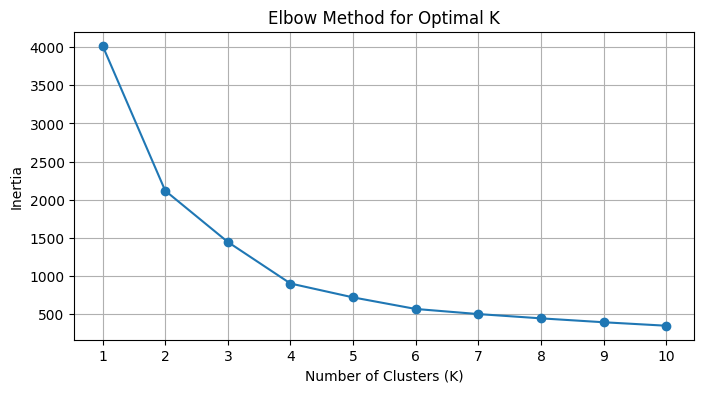

In [22]:
class ElbowMethod:
    """
    A class to determine the optimal number of clusters using the Elbow Method.
    """

    def __init__(self, preprocessor, k_range=(1, 10), random_state=42, n_init=10):
        """
        Initializes the ElbowMethod with a preprocessor, K range, and other parameters.

        Args:
            preprocessor: The data preprocessor object.
            k_range: Tuple specifying the range of K values to test (default: (1, 10)).
            random_state: Random seed for KMeans (default: 42).
            n_init: Number of times KMeans is run with different centroid seeds (default: 10).
        """
        self.preprocessor = preprocessor
        self.k_range = k_range
        self.random_state = random_state
        self.n_init = n_init

    def find_optimal_k(self, data):
        """
        Finds the optimal number of clusters using the Elbow Method.

        Args:
            data: The input data (pandas DataFrame).

        Returns:
            int: The optimal number of clusters.
        """
        # The pipeline now includes KMeans as the estimator
        pipeline = Pipeline(steps=[('preprocessor', self.preprocessor), ('kmeans', KMeans())])

        inertia = []
        for k in range(self.k_range[0], self.k_range[1] + 1):
            # Set the number of clusters for KMeans within the loop
            pipeline.set_params(kmeans__n_clusters=k, kmeans__random_state=self.random_state, kmeans__n_init=self.n_init)
            # Fit the pipeline (including preprocessor and KMeans) using only the features
            # Pass only the features data to fit_transform, no y is needed for unsupervised learning
            X = data[self.preprocessor.numerical_features + self.preprocessor.categorical_features]
            X_preprocessed = self.preprocessor.fit_transform(X)
            pipeline.named_steps['kmeans'].fit(X_preprocessed)
            inertia.append(pipeline.named_steps['kmeans'].inertia_)

        # Plot the Elbow Method graph
        plt.figure(figsize=(8, 4))
        plt.plot(range(self.k_range[0], self.k_range[1] + 1), inertia, marker='o')
        plt.title('Elbow Method for Optimal K')
        plt.xlabel('Number of Clusters (K)')
        plt.ylabel('Inertia')
        plt.xticks(range(self.k_range[0], self.k_range[1] + 1))
        plt.grid(True)
        plt.show()


elbow_method = ElbowMethod(preprocessor)
elbow_method.find_optimal_k(df_cleaned)

Enter the desired number of clusters: 6


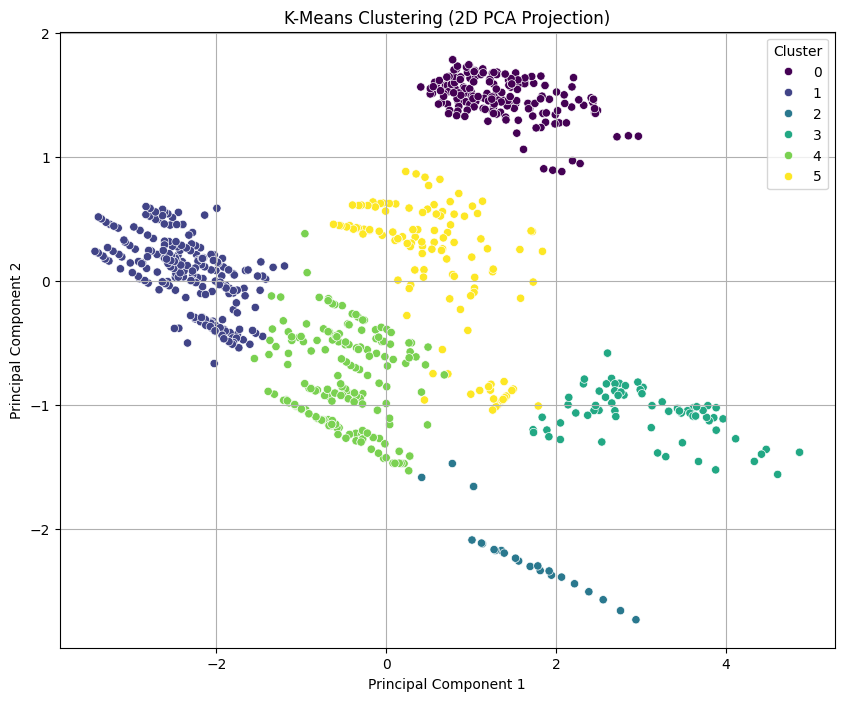


Analyzing the characteristics of each cluster:
          Tuition_USD  Living_Cost_Index     Rent_USD  Visa_Fee_USD  \
Cluster                                                               
0        32392.737430          69.465363  1286.033520    469.581006   
1         4660.185185          44.981481   370.231481    109.722222   
2         1979.166667          95.404167  1683.333333    106.833333   
3        47742.307692          77.796154  1858.974359    160.000000   
4         5920.789474          69.690526   843.631579    130.494737   
5        29488.888889          67.523932  1184.615385    217.384615   

         Insurance_USD  
Cluster                 
0           727.932961  
1           341.898148  
2          1137.500000  
3          1500.000000  
4           713.947368  
5           698.461538  

Data points in Cluster 0:
       Country            City                           University                  Program     Level  Duration_Years  Tuition_USD  Living_Cost_Index  Rent

In [23]:
class KMeansClustering:
    def __init__(self, random_state=42, n_init=10):
        """
        Initializes the KMeansClustering object.

        Args:
            random_state (int, optional): Random seed for reproducibility. Defaults to 42.
            n_init (int, optional): Number of times the k-means algorithm will be run
                                    with different centroid seeds. Defaults to 10.
        """
        self.random_state = random_state
        self.n_init = n_init
        self.kmeans = None
        self.pca = PCA(n_components=2)
        self.clusters = None
        self.n_clusters = None

    def fit_predict(self, data, n_clusters):
        """
        Fits the KMeans model to the data and predicts cluster labels.

        Args:
            data (array-like): The input data.
            n_clusters (int): The number of clusters.

        Returns:
            array-like: The predicted cluster labels.
        """
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=self.n_clusters,
                            random_state=self.random_state,
                            n_init=self.n_init)
        self.clusters = self.kmeans.fit_predict(data)
        return self.clusters

    def transform_pca(self, data):
        """
        Transforms the data using PCA.

        Args:
            data (array-like): The input data.

        Returns:
            array-like: The transformed data.
        """
        return self.pca.fit_transform(data)

    def visualize_clusters(self, data_pca):
        """
        Visualizes the clusters using PCA.

        Args:
            data_pca (array-like): The PCA-transformed data.
        """
        pca_df = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
        pca_df['Cluster'] = self.clusters
        plt.figure(figsize=(10, 8))
        sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df,
                        palette='viridis', legend='full')
        plt.title('K-Means Clustering (2D PCA Projection)')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid(True)
        plt.show()

    def analyze_clusters(self, df_cleaned, available_numerical_features):
        """
        Analyzes the characteristics of each cluster.

        Args:
            df_cleaned (DataFrame): The cleaned DataFrame.
            available_numerical_features (list): List of numerical features.
        """
        df_cleaned['Cluster'] = self.clusters
        print("\nAnalyzing the characteristics of each cluster:")
        print(df_cleaned.groupby('Cluster')[available_numerical_features].mean())

        # Show data points in each cluster
        for cluster in range(self.n_clusters):
            print(f"\nData points in Cluster {cluster}:")
            cluster_data = df_cleaned[df_cleaned['Cluster'] == cluster]
            print(cluster_data.to_string())  # Print the entire DataFrame for the cluster

#Implement
n_clusters = int(input("Enter the desired number of clusters: "))  # Get user input
kmeans_clustering = KMeansClustering()
clusters = kmeans_clustering.fit_predict(preprocessed_data, n_clusters)  # Pass n_clusters
data_pca = kmeans_clustering.transform_pca(preprocessed_data)
kmeans_clustering.visualize_clusters(data_pca)
kmeans_clustering.analyze_clusters(df_cleaned, available_numerical_features)

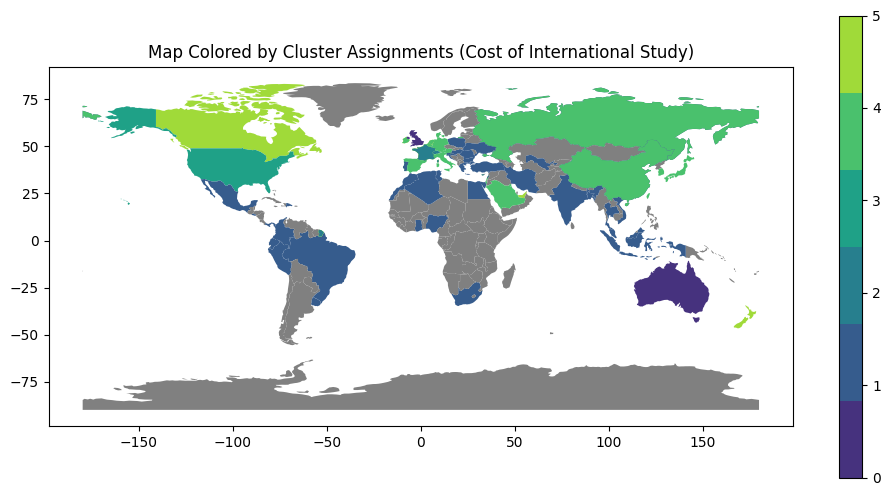

In [29]:
#Map the cluster in to world 2d map


# URL of the shapefile on Natural Earth website
shapefile_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"

# Local filename for the downloaded zip file
zip_filename = "ne_110m_admin_0_countries.zip"

# Download the shapefile using urllib.request
urllib.request.urlretrieve(shapefile_url, zip_filename)

# Extract the downloaded zip file
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("ne_110m_admin_0_countries") # Extract to a subfolder

# Get the current working directory
current_directory = os.getcwd()

# Construct the full path to the shapefile
shapefile_path = os.path.join(current_directory, "ne_110m_admin_0_countries", "ne_110m_admin_0_countries.shp")

# Load the world map data using the full path
world = gpd.read_file(shapefile_path)

class EarthMapVisualizer:
    """
    A class to visualize Earth map colored by cluster assignments.
    """

    class Builder:
        def __init__(self):
            self.cluster_data = None
            self.world_map = None
            self.color_map = 'viridis'
            self.title = None

        def with_cluster_data(self, cluster_data):
            self.cluster_data = cluster_data
            return self

        def with_world_map(self, world_map):
            self.world_map = world_map
            return self

        def with_color_map(self, color_map):
            self.color_map = color_map
            return self

        def with_title(self, title):
            self.title = title
            return self

        def build(self):
            return EarthMapVisualizer(self)

    def __init__(self, builder):
        self.cluster_data = builder.cluster_data
        self.world_map = builder.world_map
        self.color_map = builder.color_map
        self.title = builder.title

    def _replace_country_names(self):
        """Replaces country names for consistency."""
        country_replacements = {
            'USA': 'United States of America',
            'UK': 'United Kingdom',
            'UAE': 'United Arab Emirates'
        }
        self.cluster_data['Country'] = self.cluster_data['Country'].replace(country_replacements)

    def visualize(self):

        """Visualizes the map."""

        self._replace_country_names()

        merged_data = self.world_map.merge(self.cluster_data, left_on='ADMIN', right_on='Country', how='left')

        # Set 'Cluster' to -1 for countries not in cluster_data (no data)
        merged_data['Cluster'] = merged_data['Cluster'].fillna(-1)

        fig, ax = plt.subplots(figsize=(12, 6))

        # Create a custom colormap with gray for -1 (no data)
        from matplotlib.colors import ListedColormap
        cmap = ListedColormap(sns.color_palette('viridis', len(cluster_data['Cluster'].unique())))
        cmap.set_under('gray')

        # Plot with the custom colormap
        merged_data.plot(column='Cluster', cmap=cmap, ax=ax, legend=True, vmin=0)

        ax.set_title(self.title)
        plt.show()

# Implement
cluster_data = df_cleaned[['Country', 'Cluster']].drop_duplicates()

visualizer = EarthMapVisualizer.Builder() \
    .with_cluster_data(cluster_data) \
    .with_world_map(world) \
    .with_color_map('viridis') \
    .with_title('Map Colored by Cluster Assignments (Cost of International Study)') \
    .build()

visualizer.visualize()

In [13]:
class Predictor:
    def __init__(self, kmeans_model, preprocessor, numerical_features):
        self.kmeans_model = kmeans_model
        self.preprocessor = preprocessor
        self.numerical_features = numerical_features

    def predict(self, user_input):
        """
        Predicts the cluster for user input.

        Args:
            user_input (dict): A dictionary containing the user input
                               for the features used in clustering.

        Returns:
            int: The predicted cluster label.
        """
        # Convert user input to a DataFrame, only using numerical features
        user_input_df = pd.DataFrame([user_input])
        user_input_numerical = user_input_df[self.numerical_features]
        preprocessed_input = self.preprocessor.transform(user_input_numerical)

        # Make the prediction
        predicted_cluster = self.kmeans_model.kmeans.predict(preprocessed_input)[0]

        return predicted_cluster


predictor = Predictor(kmeans_clustering, preprocessor, available_numerical_features)

# Get user input for the relevant features (only numerical features)
user_input = {
    'Tuition_USD': float(input("Enter Tuition (USD): ")),
    'Living_Cost_Index': float(input("Enter Living Cost Index: ")),
    'Rent_USD': float(input("Enter Rent (USD): ")),
    'Visa_Fee_USD': float(input("Enter Visa Fee (USD): ")),
    'Insurance_USD': float(input("Enter Insurance (USD): "))
}

# Predict the cluster
predicted_cluster = predictor.predict(user_input)

# Print the result
print(f"The predicted cluster for the input is: {predicted_cluster}")

Enter Tuition (USD): 5800
Enter Living Cost Index: 28
Enter Rent (USD): 600
Enter Visa Fee (USD): 60
Enter Insurance (USD): 600
The predicted cluster for the input is: 1
